In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# covid <a name="top-of-covid-notebook"></a>
> Visualise the John Hopkins Covid-19 dataset.

In [ ]:
#hide
from covid.core import *

## Contents
1. [Introduction](#covid-intro)
2. [Installation](#covid-install)
3. [Graphing current counts](#covid-current)
4. [Graphing time series counts](#covid-timeseries)
5. [Graphing current and time series counts using Covid API](#covid-api)

## 1. Introduction <a name="covid-intro"></a>
#### [back](#top-of-covid-notebook)

The `covid` module provides convenience utilities for graphing the covid-19 dataset published by John Hopkins University (JHU) [here](https://github.com/CSSEGISandData/COVID-19).  The JHU dataset is updated daily with the latest in separate time series csv files covering [here](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series):
* `time_series_covid19_confirmed_global.csv`
* `time_series_covid19_deaths_global.csv`
* `time_series_covid19_recovered_global.csv`

Daily reports are kept in [this directory](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports) and conform to the format `dd-mm-2020.csv`.

## 2. Installation <a name="covid-install"></a>
#### [back](#top-of-covid-notebook)

This code is not yet in PyPI.  You can clone the repo and the corresponding functions described below will all be available in the accompanying `covid` module.  The `covid` module has the following dependencies which will need to be pip installed: `requests`,`pandas`,`matplotlib`,`seaborn`

## 3. Graphing current counts <a name="covid-current"></a>
#### [back](#top-of-covid-notebook)

You can use `getCountriesDailyReport` to obtain a `pandas` dataframe `df` holding the latest values for each of `["Confirmed","Deaths","Recovered"]` by both `Province_State` and `Country_Region` as follows:

In [ ]:
df = getCountriesDailyReport(getYesterday())

You can view the structure of `df` as follows:

In [ ]:
n = 5
nrows,ncols = df.shape
print(f'df has {nrows} rows and {ncols} columns with column names {df.columns.to_list()}')
print(f'First {n} rows are:')
print(df.iloc[:n,:])

df has 3430 rows and 12 columns with column names ['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key']
First 5 rows are:
      FIPS     Admin2  Province_State Country_Region         Last_Update  \
0  45001.0  Abbeville  South Carolina             US 2020-03-28 23:05:37   
1  22001.0     Acadia       Louisiana             US 2020-03-28 23:05:37   
2  51001.0   Accomack        Virginia             US 2020-03-28 23:05:37   
3  16001.0        Ada           Idaho             US 2020-03-28 23:05:37   
4  19001.0      Adair            Iowa             US 2020-03-28 23:05:37   

         Lat       Long_  Confirmed  Deaths  Recovered  Active  \
0  34.223334  -82.461707          3       0          0       0   
1  30.295065  -92.414197          9       1          0       0   
2  37.767072  -75.632346          2       0          0       0   
3  43.452658 -116.241552         76       0          0       0 

You can plot this data aggregated by country and `kind` as follows.  Note here that `setDefaults` configures graphs to be drawn using the [seaborn](https://seaborn.pydata.org/introduction.html) visualisation library:

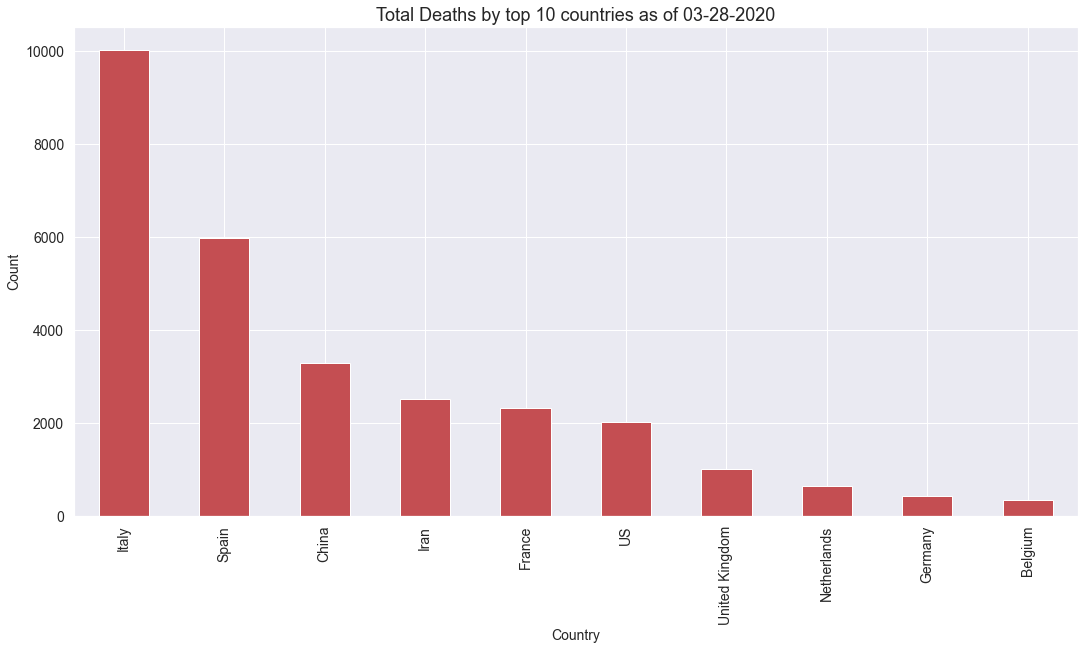

In [ ]:
setDefaults()
plotCountriesDailyReport(getCountriesDailyReport(getYesterday()), color='r', kind='Deaths')

## 4. Graphing time series counts <a name="covid-timeseries"></a>
#### [back](#top-of-covid-notebook)

We can look at how infection and death counts have varied for a county over time if we aggregate by doing a `groupby` on `country`.  We should see an equal number of values per country following this aggregation:  

In [ ]:
df = procTimeSeriesConfirmed()
print(f'Found {df.shape} (rows, cols) of cols={df.columns.values}')
ddf = df.groupby('country')['Confirmed'].count().sort_values(ascending=True)
print(f'max={ddf.max()}, min={ddf.min()}, count={len(ddf)}')

Found (11859, 2) (rows, cols) of cols=['country' 'Confirmed']
max=67, min=67, count=177


Now we can plot a time series of confirmed cases of Covid-19 in China, Italy, US and UK as follows:

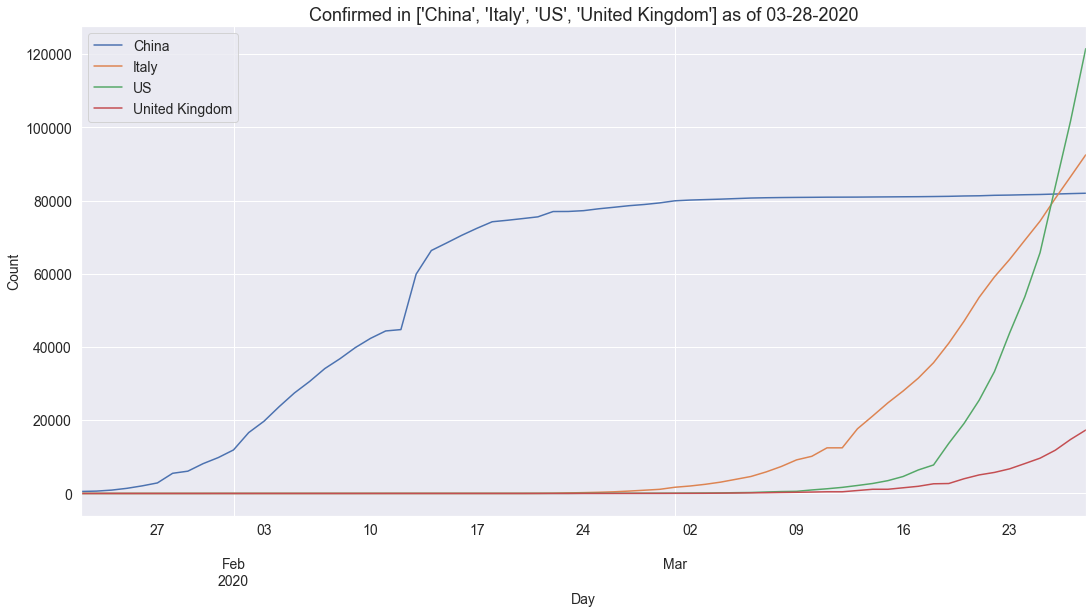

In [ ]:
plotCountryTimeSeries(df, ['China', 'Italy', 'US', 'United Kingdom'], 'Confirmed')

And we can plot a time series of recorded deaths in these same countries as follows:

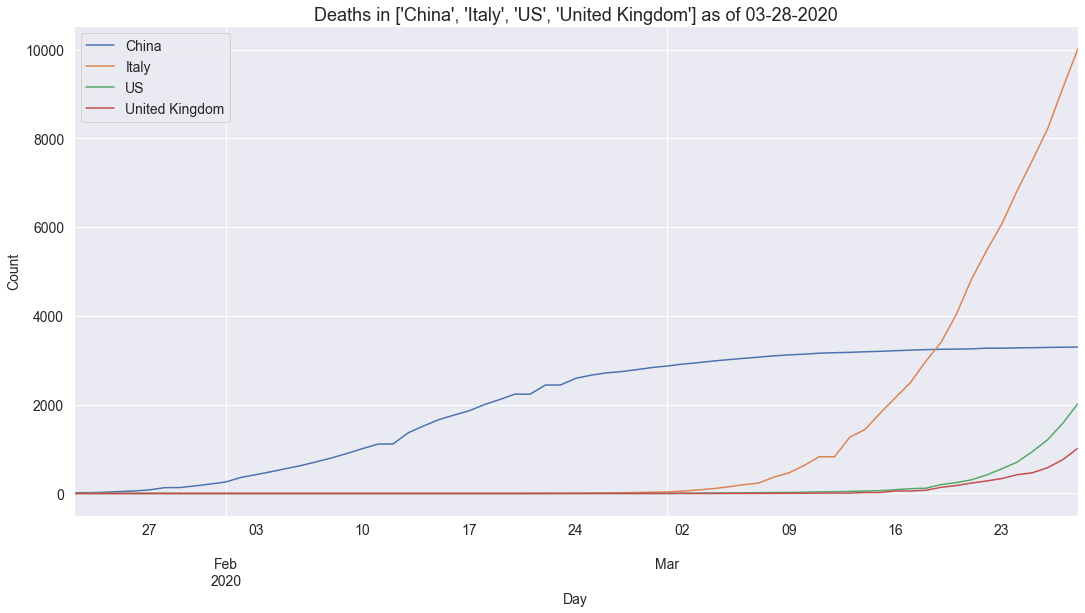

In [ ]:
plotCountryTimeSeries(procTimeSeriesDeaths(), ['China', 'Italy', 'US', 'United Kingdom'], 'Deaths')

## 5. Graphing current and time series counts using Covid API <a name="covid-api"></a>
#### [back](#top-of-covid-notebook)

[This site](https://covid19api.com/) details an API that nicely wraps up the same JHU dataset and presents it as `json` via a REST API which allows us to go from API call to formatted graph showing cases and deaths by country as follows:

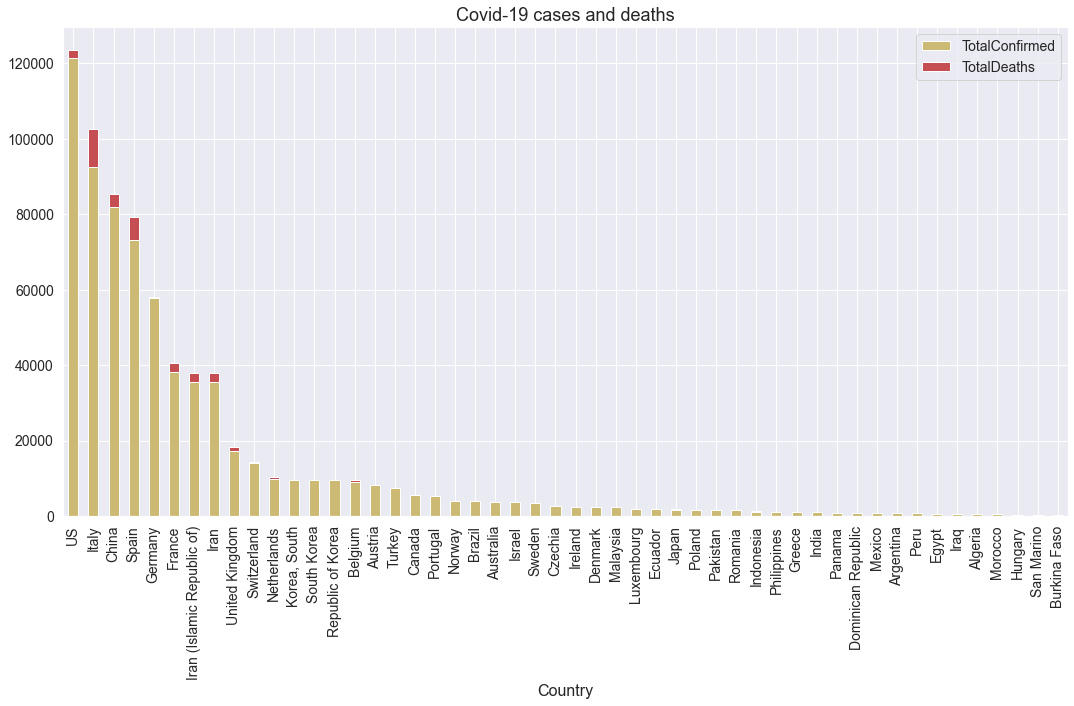

In [ ]:
plotCountriesDailyReportFromAPI()

Note that not all the country names are fully normalised - Iran and South Korea appear twice.  You can normalise the data by passing in a `normalise=True` flag:

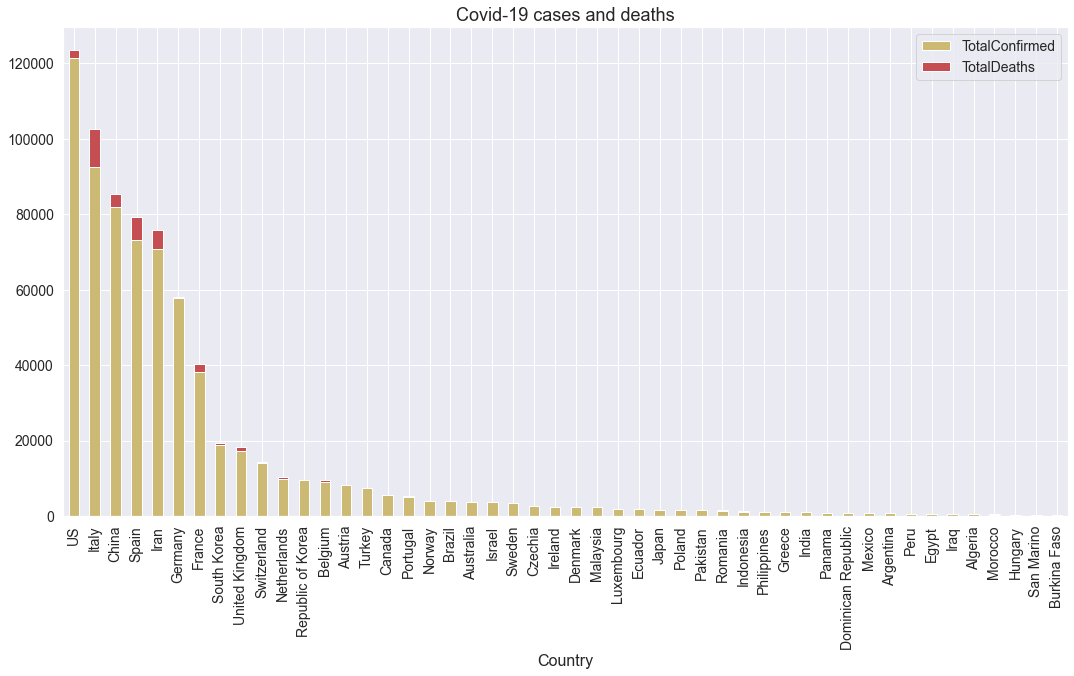

In [ ]:
plotCountriesDailyReportFromAPI(normalised=True)

It's also possible to do timeseries representation using this API by country:

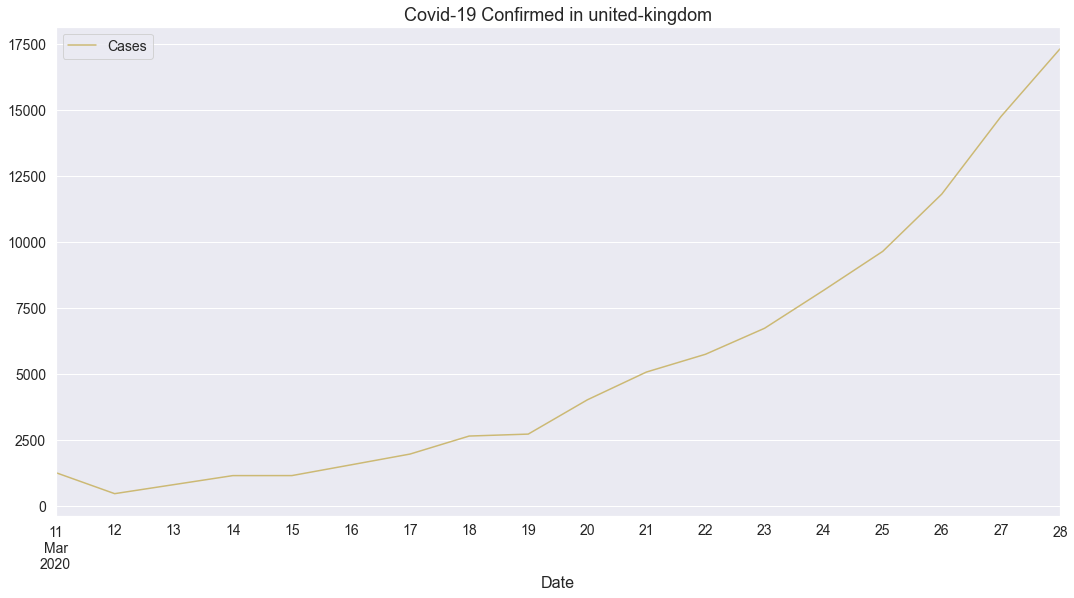

In [ ]:
plotCategoryByCountry('Confirmed', 'united-kingdom')

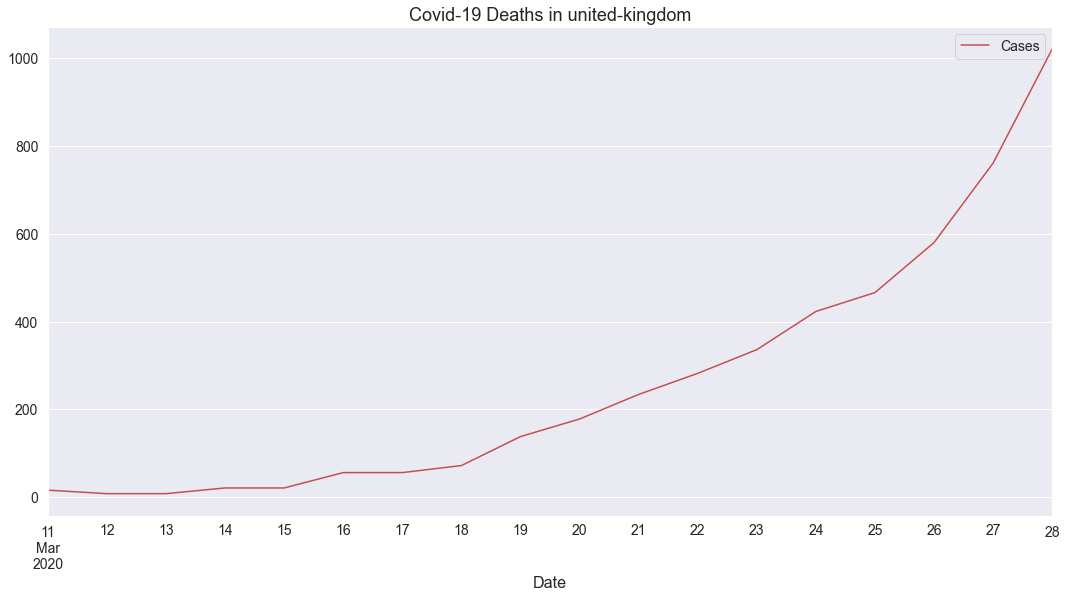

In [ ]:
plotCategoryByCountry('Deaths', 'united-kingdom', color='r')